In [1]:
from pathlib import Path

from sainsc import read_StereoSeq_bins

In [2]:
data_path = Path("data") / "StereoSeq"
analysis_path = Path("embryo")

stereo_seq_file_embryo = data_path / "E16.5_E1S3_GEM_bin1.tsv.gz"

# HVG/SVG files
HVG_file = analysis_path / "HVG_bin50.csv"
SVG_file = analysis_path / "MoranI_bin50.csv"

In [3]:
analysis_path.mkdir(exist_ok=True, parents=True)

In [4]:
stereo_bin50 = read_StereoSeq_bins(stereo_seq_file_embryo, bin_size=50, n_threads=16)

print(stereo_bin50)

AnnData object with n_obs × n_vars = 339990 × 28633
    uns: 'file_header', 'resolution', 'bin_size'
    obsm: 'spatial'


# Find Gene of iterest

For this we use the binned (size=50) dataset, so each bin approximates the size of a cell and can be used to find variable genes

In [5]:
import scanpy as sc
import seaborn as sns

In [6]:
sc.pp.calculate_qc_metrics(stereo_bin50, inplace=True)

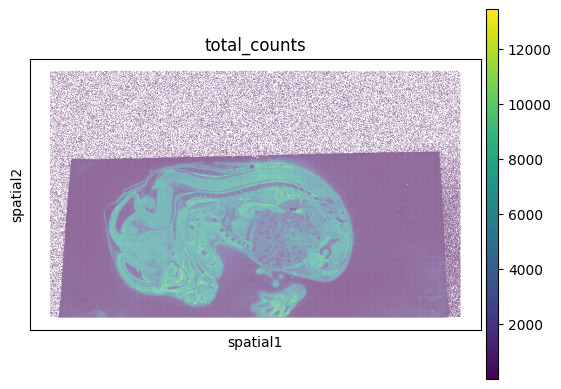

In [7]:
sc.pl.spatial(stereo_bin50, color="total_counts", spot_size=1)

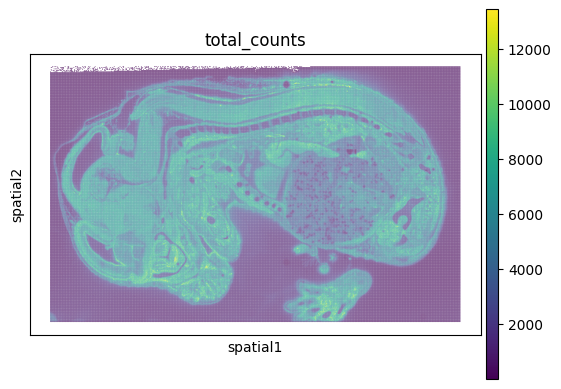

In [8]:
stereo_bin50 = stereo_bin50[
    (stereo_bin50.obsm["spatial"][:, 0] > 110)
    & (stereo_bin50.obsm["spatial"][:, 0] <= 670)
    & (stereo_bin50.obsm["spatial"][:, 1] > 180),
    :,
]

sc.pl.spatial(stereo_bin50, color="total_counts", spot_size=1)

In [9]:
sc.pp.calculate_qc_metrics(stereo_bin50, inplace=True)

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


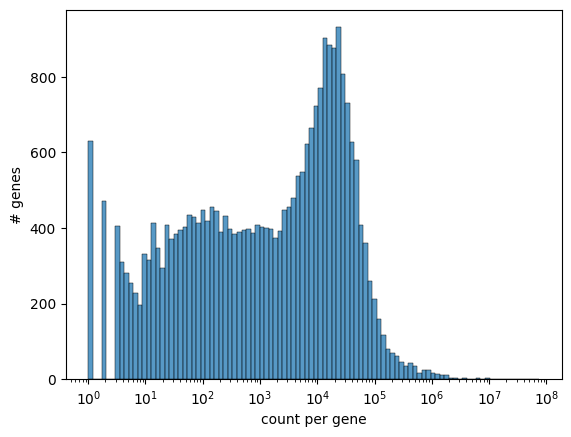

In [10]:
ax = sns.histplot(stereo_bin50.var["total_counts"], log_scale=(True, False), bins=100)
_ = ax.set(xlabel="count per gene", ylabel="# genes")

In [11]:
sc.pp.filter_cells(stereo_bin50, min_counts=1_000)
sc.pp.filter_genes(stereo_bin50, min_counts=100)

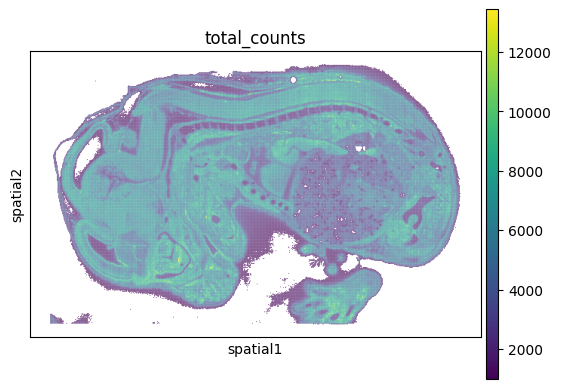

In [12]:
sc.pl.spatial(stereo_bin50, color="total_counts", spot_size=1)

## Detect (highly/spatially) variable genes

In [14]:
sc.pp.highly_variable_genes(stereo_bin50, n_top_genes=2_000, flavor="seurat_v3")

In [15]:
stereo_bin50.var.loc[stereo_bin50.var["highly_variable"], []].to_csv(HVG_file)

### Spatially

In [16]:
import squidpy as sq

In [17]:
sq.gr.spatial_neighbors(
    stereo_bin50,
    coord_type="grid",
    n_neighs=4,
    n_rings=1,
    set_diag=False,
    key_added="spatial",
)

In [18]:
sc.pp.highly_variable_genes(stereo_bin50, n_top_genes=10_000, flavor="seurat_v3")

In [19]:
sq.gr.spatial_autocorr(stereo_bin50, mode="moran", n_jobs=8)

In [20]:
stereo_bin50.uns["moranI"].head()

,I,pval_norm,var_norm,pval_norm_fdr_bh
Myl2,0.925371,0.0,0.000004,0.0
Ttr,0.914625,0.0,0.000004,0.0
Myh7,0.897849,0.0,0.000004,0.0
Tuba1a,0.890226,0.0,0.000004,0.0
Hbb-bs,0.889812,0.0,0.000004,0.0


In [21]:
stereo_bin50.uns["moranI"].nlargest(2_000, "I").rename_axis("gene").to_csv(SVG_file)

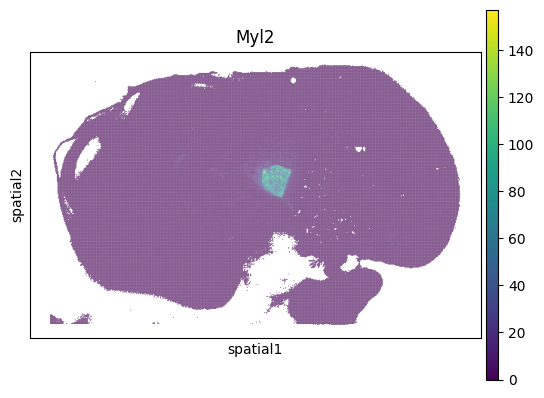

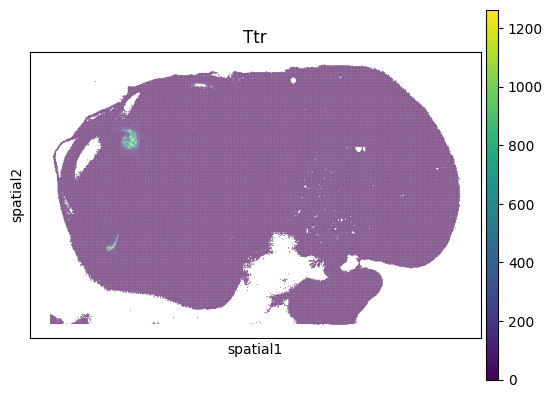

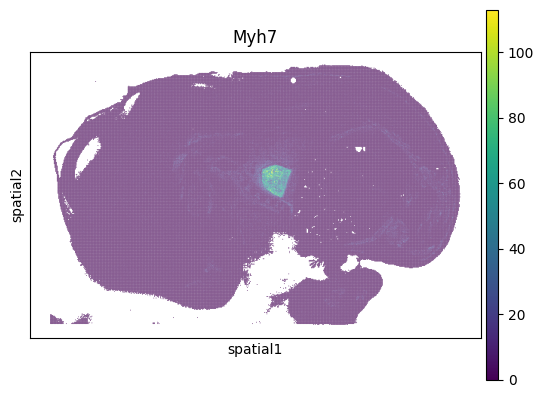

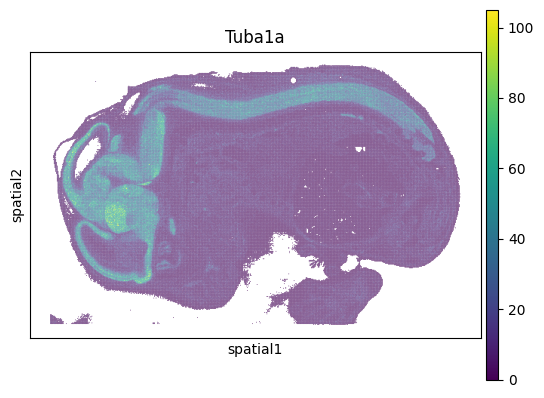

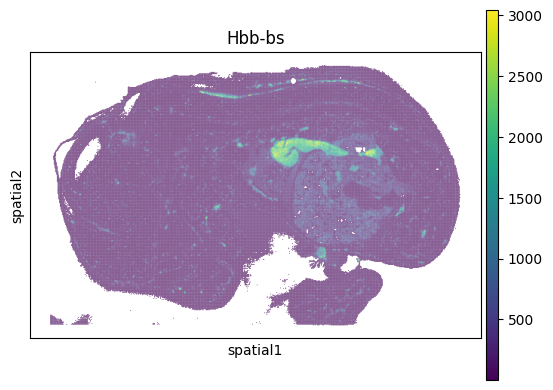

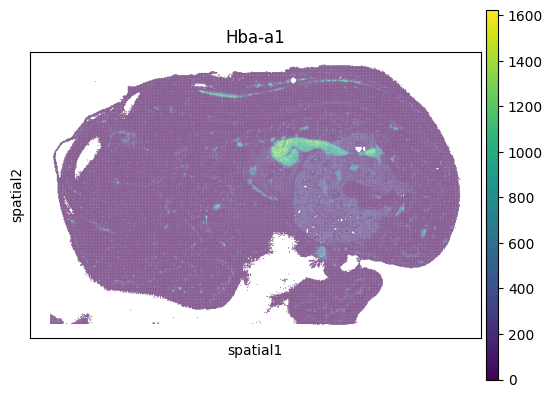

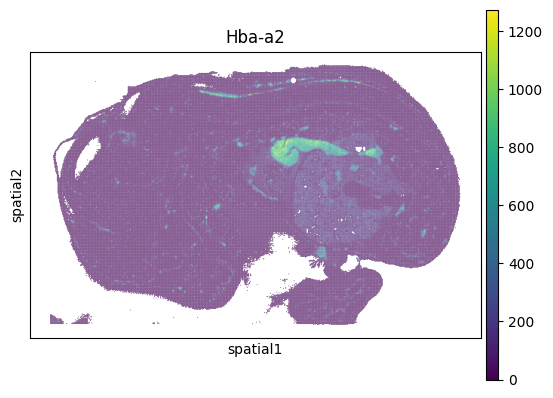

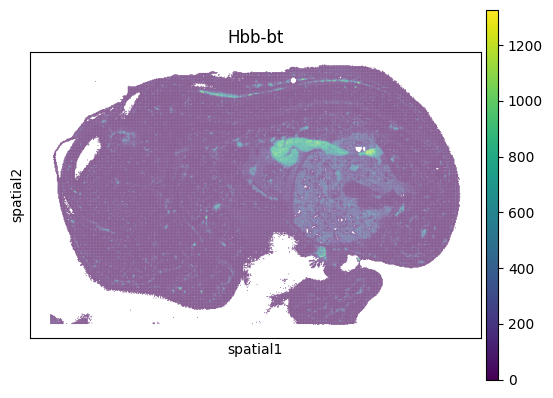

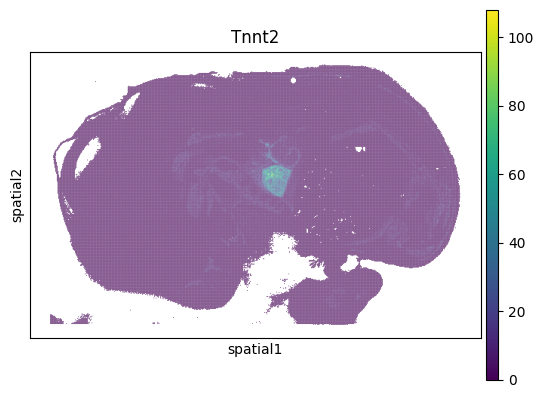

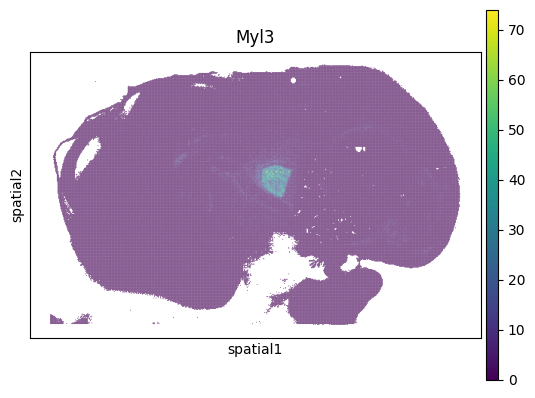

In [27]:
for i in range(10):
    sc.pl.spatial(stereo_bin50, color=stereo_bin50.uns["moranI"].index[i], spot_size=1)